# APOD Data Quality, EDA, and Visualization

This notebook inspects the NASA APOD dataset stored in SQLite, runs lightweight data-quality checks, and produces focused visuals for media types, text content, and posting patterns.

**Run guide**
- Execute cells top-to-bottom after updating the SQLite file if needed.
- Key outputs: quality report, temporal activity plots, media mix, text vocabulary, and HD availability.
- Data path is inferred from this notebook location; adjust `DB_PATH` below if you move the database.

**Sections**
1) Load data and quick snapshot
2) Data quality checks
3) Feature engineering
4) Temporal patterns
5) Media mix and HD availability
6) Text content
7) Attribution notes

In [24]:
import sqlite3
from pathlib import Path
import json
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid")

# In notebooks __file__ is undefined; infer project root from notebook location
BASE_DIR = Path.cwd().resolve().parent
DB_PATH = BASE_DIR / "data" / "apod.db"

In [25]:
def load_apod(db_path: Path) -> pd.DataFrame:
    if not db_path.exists():
        raise FileNotFoundError(f"Missing database at {db_path}")
    with sqlite3.connect(db_path) as con:
        df = pd.read_sql_query("SELECT * FROM apod_entries", con)
    # Normalize column names
    df.columns = [c.strip().lower() for c in df.columns]
    # Trim whitespace
    for col in ["title", "explanation", "media_type", "url", "hdurl", "thumbnail_url", "copyright"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
    # Parse dates
    df["date_dt"] = pd.to_datetime(df["date"], errors="coerce")
    # Drop exact duplicate rows
    df = df.drop_duplicates()
    return df


df = load_apod(DB_PATH)
df.head()

,date,title,explanation,media_type,url,hdurl,thumbnail_url,service_version,copyright,fetched_at,date_dt
0,2025-11-09,Road to the Galactic Center,Does the road to our galaxy's center go throug...,image,https://apod.nasa.gov/apod/image/2511/Monument...,https://apod.nasa.gov/apod/image/2511/Monument...,None,v1,Michael Abramyan,2025-12-08 23:27:19,2025-11-09
1,2025-11-10,Micro Moon vs. Super Moon,What was so super about Wednesday's supermoon?...,image,https://apod.nasa.gov/apod/image/2511/SuperMic...,https://apod.nasa.gov/apod/image/2511/SuperMic...,None,v1,"Şenol Şanlı""",2025-12-08 23:27:19,2025-11-10
2,2025-11-11,Jupiter in Ultraviolet from Hubble,Jupiter looks a bit different in ultraviolet l...,image,https://apod.nasa.gov/apod/image/2511/JupiterU...,https://apod.nasa.gov/apod/image/2511/JupiterU...,None,v1,None,2025-12-08 23:27:19,2025-11-11
3,2025-11-12,A Super Lunar Corona,What are those colorful rings around the Moon?...,image,https://apod.nasa.gov/apod/image/2511/SuperLun...,https://apod.nasa.gov/apod/image/2511/SuperLun...,None,v1,Eric Houck,2025-12-08 23:27:19,2025-11-12
4,2025-11-13,Orion and the Running Man,Few cosmic vistas can excite the imagination l...,image,https://apod.nasa.gov/apod/image/2511/lrg_gaba...,https://apod.nasa.gov/apod/image/2511/lrg_gaba...,None,v1,R. Jay Gabany,2025-12-08 23:27:19,2025-11-13


### Quick Snapshot
Row/column counts, date coverage, and first few rows to sanity-check the load step.

In [26]:
date_min = df["date_dt"].min()
date_max = df["date_dt"].max()

snapshot = {
    "rows": len(df),
    "columns": df.shape[1],
    "date_min": date_min.date().isoformat() if pd.notna(date_min) else None,
    "date_max": date_max.date().isoformat() if pd.notna(date_max) else None,
}
print(json.dumps(snapshot, indent=2))

print("\nColumn summary (non-null counts):")
print(df.notna().sum().sort_values(ascending=False).to_string())

print("\nSample rows:")
df.head(3)

{
  "rows": 35,
  "columns": 11,
  "date_min": "2025-11-09",
  "date_max": "2025-12-13"
}

Column summary (non-null counts):
date               35
title              35
explanation        35
media_type         35
url                35
hdurl              35
thumbnail_url      35
service_version    35
copyright          35
fetched_at         35
date_dt            35

Sample rows:


,date,title,explanation,media_type,url,hdurl,thumbnail_url,service_version,copyright,fetched_at,date_dt
0,2025-11-09,Road to the Galactic Center,Does the road to our galaxy's center go throug...,image,https://apod.nasa.gov/apod/image/2511/Monument...,https://apod.nasa.gov/apod/image/2511/Monument...,None,v1,Michael Abramyan,2025-12-08 23:27:19,2025-11-09
1,2025-11-10,Micro Moon vs. Super Moon,What was so super about Wednesday's supermoon?...,image,https://apod.nasa.gov/apod/image/2511/SuperMic...,https://apod.nasa.gov/apod/image/2511/SuperMic...,None,v1,"Şenol Şanlı""",2025-12-08 23:27:19,2025-11-10
2,2025-11-11,Jupiter in Ultraviolet from Hubble,Jupiter looks a bit different in ultraviolet l...,image,https://apod.nasa.gov/apod/image/2511/JupiterU...,https://apod.nasa.gov/apod/image/2511/JupiterU...,None,v1,None,2025-12-08 23:27:19,2025-11-11


## Data Quality Checks
Validates required fields, date bounds, duplicate dates, allowed media types, and empty strings. The helper below returns a concise report for quick review.

In [27]:
APOD_EPOCH = pd.Timestamp("1995-06-16")
ALLOWED_MEDIA_TYPES = {"image", "video", "other"}


def validate(df: pd.DataFrame) -> dict:
    report = {
        "total_rows": int(len(df)),
        "missing": {},
        "invalid_dates": {},
        "duplicates": {},
        "invalid_media_type": {},
        "empty_strings": {},
    }
    required = ["date", "title", "media_type", "url"]
    for col in required:
        report["missing"][col] = int(df[col].isna().sum())

    invalid_format = df[df["date_dt"].isna()].shape[0]
    out_of_range = df[(df["date_dt"] < APOD_EPOCH) | (df["date_dt"] > pd.Timestamp("today"))].shape[0]
    report["invalid_dates"] = {
        "invalid_format_count": int(invalid_format),
        "out_of_range_count": int(out_of_range),
    }

    dup_dates = df[df.duplicated(subset=["date"], keep=False)]["date"].tolist()
    report["duplicates"] = {"by_date": len(dup_dates), "unique_dates": len(set(dup_dates))}

    invalid_media = df[~df["media_type"].isin(ALLOWED_MEDIA_TYPES)]
    report["invalid_media_type"] = {
        "count": int(len(invalid_media)),
        "samples": invalid_media[["date", "media_type"]].head(5).to_dict(orient="records"),
    }

    for col in ["title", "explanation", "url"]:
        empties = df[df[col].fillna("").str.strip() == ""]
        report["empty_strings"][col] = int(len(empties))

    return report


quality_report = validate(df)
quality_report

{'total_rows': 35,
 'missing': {'date': 0, 'title': 0, 'media_type': 0, 'url': 0},
 'invalid_dates': {'invalid_format_count': 0, 'out_of_range_count': 0},
 'duplicates': {'by_date': 0, 'unique_dates': 0},
 'invalid_media_type': {'count': 0, 'samples': []},
 'empty_strings': {'title': 0, 'explanation': 0, 'url': 0}}

### Quality Summary
Use the JSON report above to confirm required columns, date validity, and media-type consistency before exploring visuals.

## Feature Engineering
Adds weekday and year-month helpers, extracts lightweight word tokens from explanations, and prepares aggregates for the visuals that follow.

In [28]:
df["weekday"] = df["date_dt"].dt.day_name()
df["year_month"] = df["date_dt"].dt.to_period("M")

# Word tokens from explanations (very light cleaning)
def extract_words(text: str) -> list:
    tokens = re.findall(r"[A-Za-z]{4,}", text.lower())
    return tokens

all_words = df["explanation"].dropna().apply(extract_words)
word_freq = pd.Series([w for words in all_words for w in words]).value_counts()

media_by_date = df.groupby("date_dt")["media_type"].value_counts().unstack(fill_value=0)
weekday_counts = df["weekday"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    fill_value=0,
)
copyright_counts = df["copyright"].replace({"nan": "Unknown", "None": "Unknown", "": "Unknown"}).fillna("Unknown").value_counts()

## Text Content
Quick vocabulary view across explanations to see recurring themes.

### Top Words in Explanations

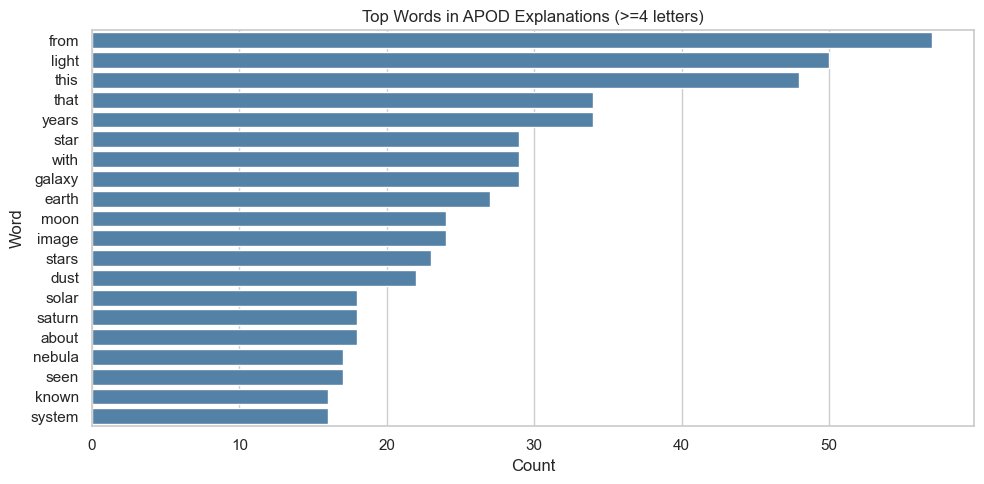

In [29]:
top_words = word_freq.head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_words.values, y=top_words.index, color="steelblue")
plt.title("Top Words in APOD Explanations (>=4 letters)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

## Temporal Patterns
Daily and weekly views help spot cadence changes or gaps.

### Media Type by Date

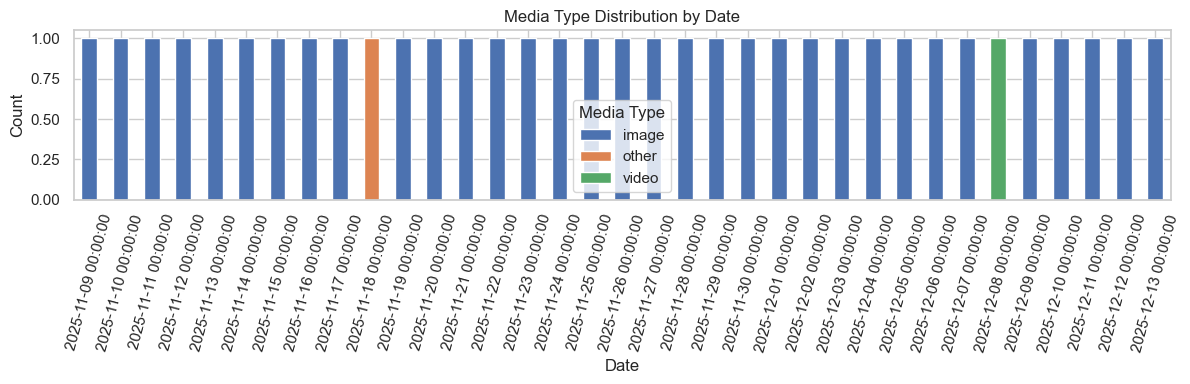

In [30]:
media_by_date.sort_index(inplace=True)
media_by_date.plot(kind="bar", stacked=True, figsize=(12, 4), color=["#4c72b0", "#dd8452", "#55a868"])
plt.title("Media Type Distribution by Date")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.legend(title="Media Type")
plt.tight_layout()
plt.show()

### Posts by Weekday

C:\Users\Satya\AppData\Local\Temp\ipykernel_13200\2729951608.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="viridis")


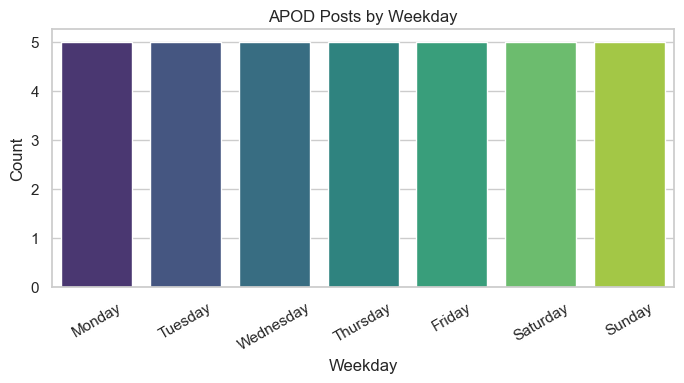

In [31]:
plt.figure(figsize=(7, 4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="viridis")
plt.title("APOD Posts by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Attribution
Who gets credited most often in the feed window.

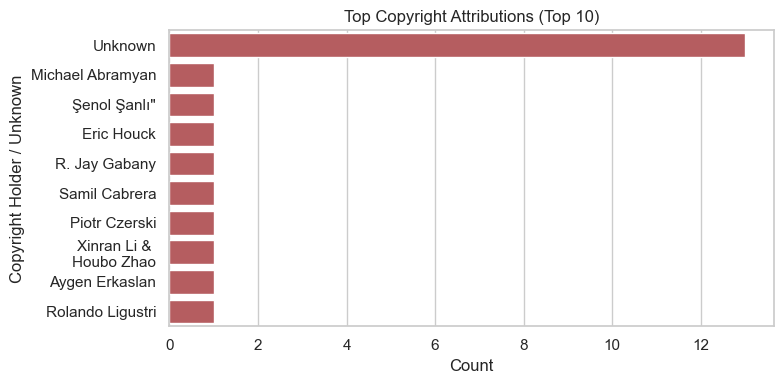

In [32]:
top_copyright = copyright_counts.head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_copyright.values, y=top_copyright.index, color="#c44e52")
plt.title("Top Copyright Attributions (Top 10)")
plt.xlabel("Count")
plt.ylabel("Copyright Holder / Unknown")
plt.tight_layout()
plt.show()

## Media Mix and HD Availability
Share of images vs videos, cadence by month, explanation lengths, and HD coverage by media type.

### Media Type Share

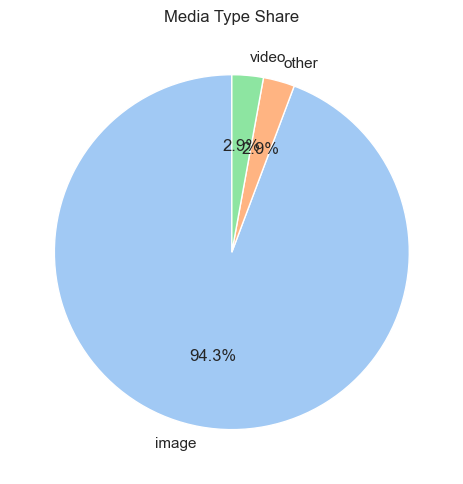

In [33]:
# Media-type share (pie)
media_counts = df["media_type"].fillna("unknown").value_counts()
plt.figure(figsize=(5, 5))
media_counts.plot.pie(autopct="%1.1f%%", startangle=90, colors=sns.color_palette("pastel"))
plt.ylabel("")
plt.title("Media Type Share")
plt.tight_layout()
plt.show()

### Activity by Month

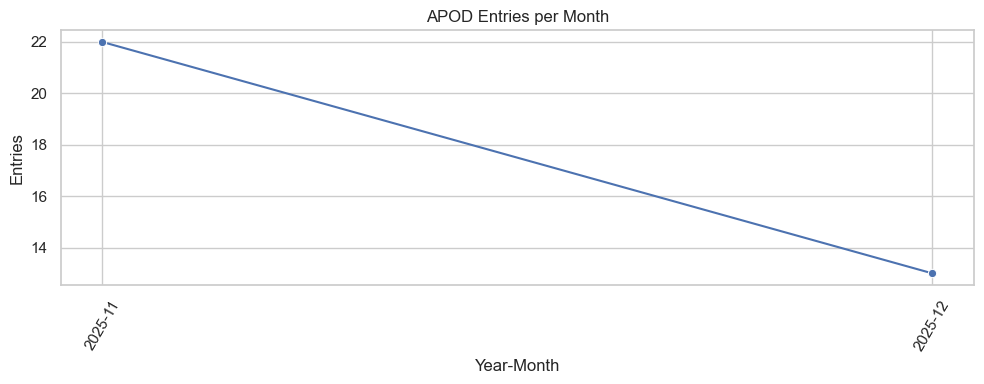

In [34]:
# Entries per month (line)
monthly_counts = df.groupby("year_month").size().sort_index()
monthly_counts.index = monthly_counts.index.astype(str)
plt.figure(figsize=(10, 4))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker="o")
plt.title("APOD Entries per Month")
plt.xlabel("Year-Month")
plt.ylabel("Entries")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

### Explanation Lengths

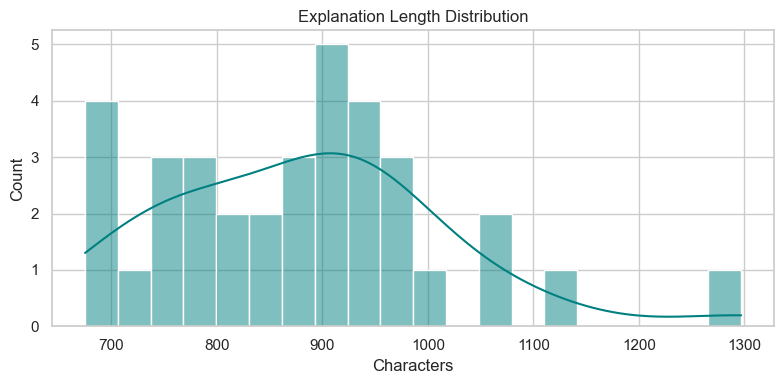

In [35]:
# Explanation length distribution
if "explanation_len" not in df.columns:
    df["explanation_len"] = df["explanation"].fillna("").str.len()
plt.figure(figsize=(8, 4))
sns.histplot(df["explanation_len"], bins=20, kde=True, color="teal")
plt.title("Explanation Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### HD Availability by Media Type

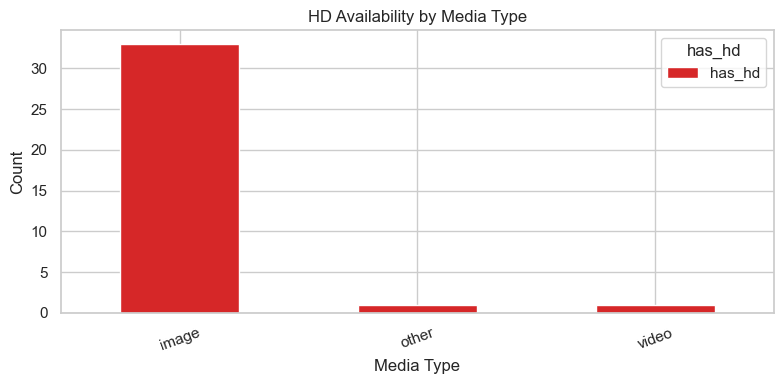

In [36]:
# HD availability by media type (stacked bar)
df["has_hd"] = df["hdurl"].notna()
hd_ct = pd.crosstab(df["media_type"].fillna("unknown"), df["has_hd"])
hd_ct = hd_ct.rename(columns={True: "has_hd", False: "no_hd"})
hd_ct.plot(kind="bar", stacked=True, color=["#d62728", "#2ca02c"], figsize=(8, 4))
plt.title("HD Availability by Media Type")
plt.xlabel("Media Type")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## Takeaways
- Quick snapshot + quality report surface gaps before analysis.
- Temporal plots (by date, weekday, month) highlight cadence changes and any outages.
- Media mix and HD availability give a fast sense of user-facing quality.
- Text vocabulary and explanation lengths reveal theme concentration; switch to the NLP pipeline for deeper insights.